In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets
import torchvision.transforms
import torch.nn.functional as F
from tqdm import tqdm
import random

In [2]:
random.seed(2022)
torch.manual_seed(2022)

cifar_train = torchvision.datasets.CIFAR10(root='/', train=True, transform=torchvision.transforms.ToTensor(), download=True)
cifar_test = torchvision.datasets.CIFAR10(root='/', train=False, transform=torchvision.transforms.ToTensor(), download=True)

batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=cifar_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=cifar_test, shuffle=True,batch_size=10000 , drop_last=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /cifar-10-python.tar.gz to /
Files already downloaded and verified


(20, 32, 32, 3)


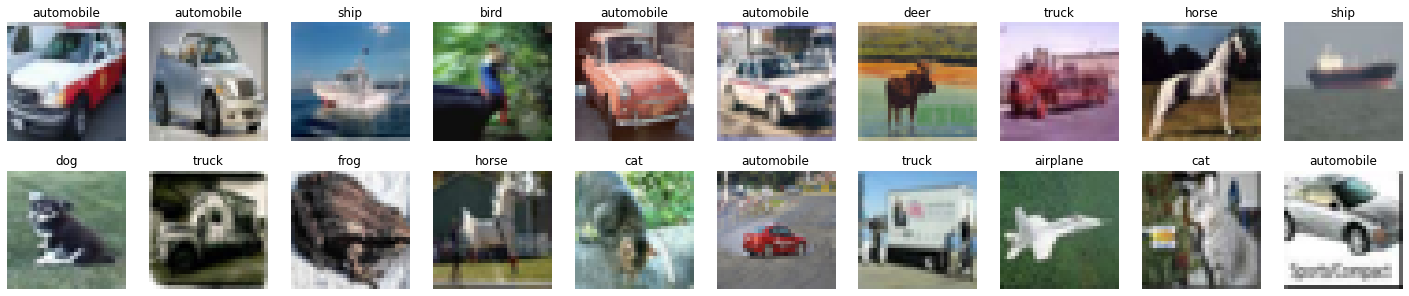

In [3]:
cifar_label = {0:'airplane', 1:'automobile', 2: 'bird', 3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
images = cifar_train.data[60:80]
labels = cifar_train.targets[60:80]
print(images.shape)
fig = plt.figure(figsize=(25,5))
for i in range(len(images)):
    ax = fig.add_subplot(2, 20/2, i+1)
    ax.imshow(images[i])
    ax.set_title(cifar_label[labels[i]])
    ax.axis('off')

In [10]:
class Classifier_opt(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim,device, output_dim, lr = 0.001, epochs = 10, activation='sigmoid',dropout=0.0, opt='sgd', momentum=0.9):
        super(Classifier_opt, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.epochs = epochs
        self.total_losses = []
        self.accuracy=[]
        self.lr = lr
        self.device = device
        self.activation = activation
        self.dropout = dropout
        self.opt=opt
        self.momentum=momentum

        self.fc1 = torch.nn.Linear(self.input_dim, self.hidden_dim[0]).to(self.device)
        self.bn1 = torch.nn.BatchNorm1d(self.hidden_dim[0]).to(self.device)
        self.dropout1 = torch.nn.Dropout(self.dropout)
        self.fc2 = torch.nn.Linear(self.hidden_dim[0], self.hidden_dim[1]).to(self.device)
        self.bn2 = torch.nn.BatchNorm1d(self.hidden_dim[1]).to(self.device)
        self.dropout2 = torch.nn.Dropout(self.dropout)
        self.fc3 = torch.nn.Linear(self.hidden_dim[1], self.hidden_dim[2]).to(self.device)
        self.bn3 = torch.nn.BatchNorm1d(self.hidden_dim[2]).to(self.device)
        self.dropout3 = torch.nn.Dropout(self.dropout)
        self.fc4 = torch.nn.Linear(self.hidden_dim[2], self.output_dim).to(self.device)
        self.dropout4 = torch.nn.Dropout(self.dropout)
        
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        
    def forward(self, x):
        if self.activation == 'relu':
            pred = self.dropout1(F.relu(self.bn1(self.fc1(x))))
            pred = self.dropout2(F.relu(self.bn2(self.fc2(pred))))
            pred = self.dropout3(F.relu(self.bn3(self.fc3(pred))))
            pred = self.dropout4(self.fc4(pred))
        else:
            pred = self.dropout1(torch.sigmoid(self.bn1(self.fc1(x))))
            pred = self.dropout2(torch.sigmoid(self.bn2(self.fc2(pred))))
            pred = self.dropout3(torch.sigmoid(self.bn3(self.fc3(pred))))
            pred = self.dropout4(self.fc4(pred))
        
        return pred

    def fit(self, data):
        criterion = torch.nn.CrossEntropyLoss().to(self.device)
        if self.opt =='sgd':
          optimizer = torch.optim.SGD(self.parameters(), lr = self.lr, momentum=self.momentum)
        elif self.opt =='adagrad':
          optimizer = torch.optim.Adagrad(self.parameters(), lr = self.lr)
        elif self.opt =='rmsprop':
          optimizer = torch.optim.RMSprop(self.parameters(), lr = self.lr)
        elif self.opt =='adam':
          optimizer = torch.optim.Adam(self.parameters(), lr = self.lr, weight_decay=0.01)
        
        for _ in range(self.epochs):
            total_loss=0
            total_accuracy=0
            for x, y in tqdm(data):
                x = x.view(-1,3072).to(self.device)
                y = y.to(self.device)
                optimizer.zero_grad()

                pred = self.forward(x)

                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
                
                correct_pred = torch.argmax(pred,1) == y
                accuracy = correct_pred.float().mean()
                total_accuracy+=accuracy.item()
                total_loss+=loss.item()

            print('Epoch {} Loss: '.format(_+1),total_loss/len(data))
            self.total_losses.append(total_loss/len(data))
            self.accuracy.append(total_accuracy/len(data))

    def evaluation(self, data):
        with torch.no_grad():
            self.eval()
            
            criterion = torch.nn.CrossEntropyLoss().to(self.device)
            for x, y in tqdm(data):
                x = x.view(-1,3072).to(self.device)
                y = y.to(self.device)
                pred = self.forward(x)
                loss = criterion(pred, y)
                correct_pred = torch.argmax(pred,1) == y
                accuracy = correct_pred.float().mean()
            print('Accuracy', accuracy.item())
        
        return accuracy.item()

    def get_weights(self):
        return [self.fc1.weight, self.fc2.weight,self.fc3.weight, self.fc4.weight]


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Classifier_opt(input_dim = 3072, hidden_dim=(512,256,128), output_dim=10,device=device, activation='relu',opt='adam')

In [12]:
model.fit(train_loader)

100%|██████████| 781/781 [00:08<00:00, 91.11it/s]


Epoch 1 Loss:  1.7312165385782337


100%|██████████| 781/781 [00:08<00:00, 92.89it/s]


Epoch 2 Loss:  1.6902727592311961


100%|██████████| 781/781 [00:08<00:00, 92.47it/s]


Epoch 3 Loss:  1.6500268762456622


100%|██████████| 781/781 [00:08<00:00, 94.56it/s]


Epoch 4 Loss:  1.6146804907868368


100%|██████████| 781/781 [00:08<00:00, 93.83it/s]


Epoch 5 Loss:  1.595439557992542


100%|██████████| 781/781 [00:08<00:00, 93.86it/s]


Epoch 6 Loss:  1.5797707364440117


100%|██████████| 781/781 [00:08<00:00, 93.56it/s]


Epoch 7 Loss:  1.5720828704431022


100%|██████████| 781/781 [00:08<00:00, 92.26it/s]


Epoch 8 Loss:  1.5621916189999647


100%|██████████| 781/781 [00:08<00:00, 93.55it/s]


Epoch 9 Loss:  1.5612494663148164


100%|██████████| 781/781 [00:08<00:00, 93.83it/s]

Epoch 10 Loss:  1.5564232872329204


In [13]:
test_x = torch.Tensor(cifar_test.data).reshape(-1,3072).to(device)
test_y = torch.Tensor(cifar_test.targets).to(device)

model.evaluation(test_loader)

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Accuracy 0.3853999972343445


0.3853999972343445

In [14]:
model.accuracy[-1]

0.448943661971831